In [50]:
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set() 
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, SVR


from datetime import datetime, timedelta
from alive_progress import alive_bar, alive_it 
import random


matches_dataset = pd.read_csv("all_matches_dataset.csv")
matches_dataset

PLAYER_STAT_VARIABLES = [var.replace("t1p1_","") for var in list(matches_dataset.columns) if ("t1p1_" in var) and (not "player" in var)]
print("All player stats variables:", ", ".join(PLAYER_STAT_VARIABLES))

many_pstat_vars = ["kills", "assists", "deaths", "kdratio", "kddiff", "adr", "fkdiff", "rating"]
few_pstat_vars = ["kills", "kdratio", "kddiff", "fkdiff", "rating"]
min_pstat_vars = ["kills", "kdratio", "rating"]

SELECTED_PSTAT_VARS = min_pstat_vars
print("SELECTED player stats variables:", ", ".join(SELECTED_PSTAT_VARS))

All player stats variables: kills, hskills, assists, fassists, deaths, kdratio, kddiff, adr, fkdiff, rating
SELECTED player stats variables: kills, kdratio, rating


In [51]:


def filter_dataset_by_date(full_df, start_dt : datetime, stop_dt : datetime, date_col_name : str = "match_date"):
    df : DataFrame = full_df.copy()
    keep_dict = {}
    if start_dt > stop_dt:
        print("datetimes were given backwards")
        temp_dt = start_dt
        start_dt = stop_dt
        stop_dt = temp_dt
    for index, row in df.iterrows():
        if not((dt:=datetime.strptime(row[date_col_name], '%Y-%m-%d')) < start_dt or dt >= stop_dt):
            # keep_indeces.append(index)
            # keep_rows.append(row)
            keep_dict[index] = row 
    return DataFrame.from_dict(keep_dict,orient="index")


def partition_dataset_by_date(df : DataFrame, stop_date = "2017-08-01", partition_length : int = 120, overlapping : bool = True, partition_shift : int = 30, pstat_vars_filter = None) -> Series:
    partitions = {}
    stop_dt = datetime.strptime(stop_date, '%Y-%m-%d')
    dt_it = datetime.now()
    if not overlapping:
        partition_shift = partition_length
    print("Partitioning dataset temporally (by date):")
    while dt_it - timedelta(days=(partition_length)) > stop_dt:
        partition = filter_dataset_by_date(df, date_col_name= "match_date", start_dt=dt_it - timedelta(days = partition_length), stop_dt=dt_it)
        date_range = f"{datetime.strftime(dt_it - timedelta(days = partition_length),'%Y-%m-%d')} -> {datetime.strftime(dt_it,'%Y-%m-%d')}"
        partitions[date_range] = partition
        print(date_range,":",partition.shape[0],"items in partition")
        dt_it = dt_it - timedelta(days=partition_shift)
    return Series(partitions)


def get_aggregate_players_stats(df : DataFrame, pstat_vars = SELECTED_PSTAT_VARS):
    teams_pstats = {}

    for index, row in df.iterrows():
        for tn in (1,2):
            # score_diff = row["t1_total_rw"] - row["t2_total_rw"] if tn==1 else row["t2_total_rw"] - row["t1_total_rw"]
            tname = row[f"t{tn}_name"]
            
            for pn in (1,2,3,4,5):
                id = f"t{tn}p{pn}_"
                pname = row[id+"player"]
                if teams_pstats.get(tname) == None:
                    teams_pstats[tname] = {}
                if teams_pstats[tname].get(pname) == None:
                    teams_pstats[tname][pname] = []
                teams_pstats[tname][pname].append({var:row[id+var] for var in pstat_vars})
    return teams_pstats


def get_active_rosters(matches_df) -> dict[str, list[str]]:
    aggregate_pstats = get_aggregate_players_stats(matches_df)
    teams_active_players = {}
    for tname in aggregate_pstats:
        team = aggregate_pstats[tname]
        players_games_played = {}
        # players_games_played =  {player: for player in team}
        for pname in team:
            player = team[pname]
            players_games_played[pname] = len(list(player))
        active_players = list(pd.Series(players_games_played).sort_values(ascending=False).iloc[:5].index)
        teams_active_players[tname] = active_players
    return teams_active_players


def get_sorted_teams_rosters(df : DataFrame, rosters, mode = "mean"):
    aggregated_teams_pstats = get_aggregate_players_stats(df)
    sorted_rosters = {}
    for tname in rosters:
        team = aggregated_teams_pstats[tname]
        pn = 0
        pratings = {}
        for pname in rosters[tname]:
            pmatches = pd.DataFrame(team[pname])
            prating_stats = pmatches.loc[:,["rating"]].describe().squeeze()
            prating_agg_val = prating_stats[mode]
            pratings[pname] = prating_agg_val
        
        sorted_rosters[tname] = list(Series(pratings).sort_values(ascending=False).index)
    return sorted_rosters

# active_rosters = get_active_rosters(recent_matches_dataset)


def make_teams_profiles(df : DataFrame, pstat_vars = SELECTED_PSTAT_VARS, mode = "mean"):
    
    rosters = get_sorted_teams_rosters(df, rosters=get_active_rosters(df))

    aggregated_teams_pstats = get_aggregate_players_stats(df, pstat_vars=pstat_vars)

    teams_profiles = {}
    for tname in rosters:
        team = aggregated_teams_pstats[tname]
        team_flattened_pstats = {}
        pn = 0
        for pname in rosters[tname]:
            pn += 1
            pmatches = pd.DataFrame(team[pname])
            pmatches_stats = pmatches.describe()
            pstats : Series = pmatches_stats.loc[[mode], :].squeeze()
            for index, value in pstats.iteritems():
                team_flattened_pstats[f"p{pn}_{index}"] = value
        teams_profiles[tname] = Series(team_flattened_pstats).astype("float32")
    return teams_profiles




-----
-----

# SETUP EVERYTHING 

-----

In [52]:

# import crawler, team_rankings_crawler_and_scraper, matches_stats_scraper


def remove_unused_pstats(df : DataFrame, keep_pstat_vars : list [str]) -> DataFrame:
    keep_cols = [var for var in list(df.columns) if not((x:=var.split("_")[-1]) in PLAYER_STAT_VARIABLES) or x in keep_pstat_vars] 
    return df.loc[:, keep_cols ]

matches_dataset = remove_unused_pstats(matches_dataset, SELECTED_PSTAT_VARS)
matches_dataset = matches_dataset.sort_values(by=["match_date"], ascending=False)

dataset_partitions = partition_dataset_by_date(matches_dataset, partition_length=180, overlapping=False)
recent_matches_dataset = dataset_partitions.iloc[0]

matches_dataset["t1_rank"].fillna(31, inplace=True)
matches_dataset["t2_rank"].fillna(31, inplace=True)

matches_dataset = matches_dataset.sort_index()

matches_dataset

Partitioning dataset temporally (by date):
2021-10-29 -> 2022-04-27 : 5362 items in partition
2021-05-02 -> 2021-10-29 : 6875 items in partition
2020-11-03 -> 2021-05-02 : 5588 items in partition
2020-05-07 -> 2020-11-03 : 6204 items in partition
2019-11-09 -> 2020-05-07 : 5177 items in partition
2019-05-13 -> 2019-11-09 : 6288 items in partition
2018-11-14 -> 2019-05-13 : 5794 items in partition
2018-05-18 -> 2018-11-14 : 7394 items in partition
2017-11-19 -> 2018-05-18 : 6675 items in partition


,match_url,match_date,winner,rw_diff,map,t1_name,t1_id,t1_rank,t1_total_rw,t1_fh_rw,...,t2p3_kdratio,t2p3_rating,t2p4_player,t2p4_kills,t2p4_kdratio,t2p4_rating,t2p5_player,t2p5_kills,t2p5_kdratio,t2p5_rating
0,/stats/matches/mapstatsid/46584/hellraisers-vs...,2017-05-17,t1,14,train,hellraisers,5310,8.0,16,13,...,0.500,0.40,LEGIJA,5,0.333,0.35,keev,5.0,0.333,0.26
1,/stats/matches/mapstatsid/62534/envy-vs-north,2018-03-08,t1,2,cobblestone,north,7533,13.0,16,8,...,0.800,1.17,Happy,21,0.700,1.15,xms,15.0,0.633,0.78
2,/stats/matches/mapstatsid/61361/fnatic-vs-gambit,2018-02-17,t1,8,inferno,fnatic,4991,5.0,16,10,...,0.583,0.76,mou,12,0.542,0.75,Dosia,7.0,0.458,0.37
3,/stats/matches/mapstatsid/57159/liquid-vs-cloud9,2017-11-12,t2,-11,overpass,liquid,5973,8.0,5,3,...,0.857,1.39,Skadoodle,10,0.810,1.10,RUSH,16.0,0.714,1.00
4,/stats/matches/mapstatsid/123194/dbl-poney-vs-ago,2021-07-04,t1,2,ancient,dbl-poney,11003,25.0,16,6,...,0.800,1.09,reatz,17,0.700,0.89,rallen,15.0,0.567,0.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62985,/stats/matches/mapstatsid/128100/hreds-vs-aab,2021-10-05,t2,-7,overpass,hreds,10116,31.0,9,7,...,0.640,0.93,Buzz,12,0.640,0.80,jarko,13.0,0.560,0.80
62986,/stats/matches/mapstatsid/96383/exploit-vs-offset,2019-12-08,t1,8,dust2,exploit,10192,31.0,16,8,...,0.500,0.78,pr,11,0.667,0.72,obj,7.0,0.542,0.51
62987,/stats/matches/mapstatsid/106567/syman-vs-tiki...,2020-08-01,t2,-8,mirage,syman,8772,31.0,8,1,...,0.667,1.32,shushan,17,0.792,1.20,Djury,10.0,0.708,0.82
62988,/stats/matches/mapstatsid/72336/nordavind-vs-3...,2018-08-22,t1,4,inferno,3dmax,4914,31.0,16,7,...,0.571,0.81,ztk,17,0.536,0.79,becker,14.0,0.571,0.69


   t1_rank  t2_rank  rw_diff  t1_total_rw  t2_total_rw
0      8.0     27.0       14           16            2
1     13.0     28.0        2           16           14
2      5.0     11.0        8           16            8
3      8.0      7.0      -11            5           16
4     25.0     24.0        2           16           14
5     10.0     18.0       -8            8           16
6      4.0      7.0        8           16            8
7      6.0      9.0       -4           12           16
8     29.0     16.0      -11            5           16
9      5.0     31.0       13           16            3
0    not upset
1    not upset
2    not upset
3    not upset
4        upset
5        upset
6    not upset
7        upset
8    not upset
9    not upset
dtype: object


([<matplotlib.patches.Wedge at 0x212a58b59f0>,
 [Text(-0.4010657385373018, 1.0242784159453566, ''),
  Text(0.40106573853730165, -1.0242784159453566, '')])

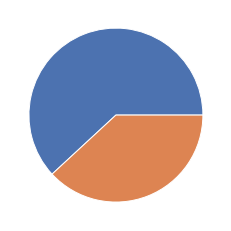

In [53]:
# eda_df = make_teams_profiles(matches_dataset)
upsets_df = matches_dataset.copy()
upsets_df = upsets_df.loc[(upsets_df["t1_rank"] != upsets_df["t2_rank"]),:]

print(upsets_df.loc[:,["t1_rank", "t2_rank", "rw_diff", "t1_total_rw", "t2_total_rw"]].head(10))
# higher_rank_team = []

# for index, row in eda_df.iterrows():
#     rank_diff = row["t1_rank"] - ["t2_rank"]
#     rw_diff = row["t1_rw_diff"] - ["t2_rw_diff"]

# eda_df["winner"].value_counts().plot.pie()


# eda_df.loc[:, ["winner", "rw_diff"]].value_counts("abs").plot()
# rank_diffs = []
# rw_diffs = []
# for index, row in eda_df.iterrows():
#     rank_diff = row["t1_rank"] - ["t2_rank"]
#     rw_diff = row["t1_rw_diff"] - ["t2_rw_diff"]

# pd.DataFrame()



# pie chart of # of games won by higher rank teams vs # of games won by lower rank team
upset_or_not = {}

for index, row in upsets_df.iterrows():
    upset_or_not[index] = "not upset" if (((row["t1_rank"] - row["t2_rank"]) * row["rw_diff"]) < 0) else "upset"
upset_or_not = Series(upset_or_not)
print(upset_or_not.head(10))

upset_frequencies = upset_or_not.value_counts(normalize=True)
plt.pie(upset_frequencies)
# line graph of x var: abs(rank disparity), y var: % of games won by the higher rank team 
# grouped bar chart for aggregate player ratings of winning teams vs losing teams



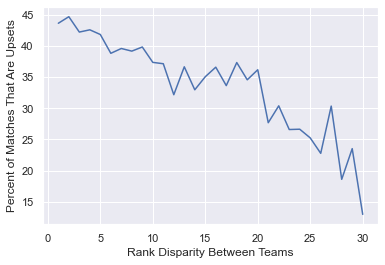

In [54]:

upsets_per_rank_diff = Series({n:0 for n in range(1,31)}, name="upsets_freq")
non_upsets_per_rank_diff = Series({n:0 for n in range(1,31)}, name="non_upsets_freq")
for index, row in upsets_df.iterrows():
    if upset_or_not[index] == "upset":
        upsets_per_rank_diff[abs(row["t1_rank"] - row["t2_rank"])] += 1
    else:
        non_upsets_per_rank_diff[abs(row["t1_rank"] - row["t2_rank"])] += 1


upsets_or_not_vs_rank_diffs = DataFrame(upsets_per_rank_diff)
upsets_or_not_vs_rank_diffs["non_upsets_freq"] = non_upsets_per_rank_diff

upsets_rel_freq_vs_rank_diffs = Series({n:0 for n in range(1,31)})
for index, row in upsets_or_not_vs_rank_diffs.iterrows():
    upsets_rel_freq_vs_rank_diffs[index] = round(row["upsets_freq"] / (row["upsets_freq"] + row["non_upsets_freq"]) * 100, 2)
plt.ylabel("Percent of Matches That Are Upsets")
plt.xlabel("Rank Disparity Between Teams")
plt.plot(upsets_rel_freq_vs_rank_diffs.index, upsets_rel_freq_vs_rank_diffs.values)

-----
-----

# WINNER PREDICTOR MODELS

-----

In [55]:
def convert_dataset_for_classification_models(df : DataFrame, seed : int = 1, test_set_size : float = 0.3):
    
    teams_profiles : dict[str,Series] = make_teams_profiles(df, pstat_vars=SELECTED_PSTAT_VARS)

    # convert all unranked teams to have rank of 31st position
    model_dataset = df.copy()
    model_dataset["t1_rank"].fillna(31, inplace=True)
    model_dataset["t2_rank"].fillna(31, inplace=True)

    # extract data for each team, extract player stats later
    teams_stats = model_dataset.loc[:,["t1_rank", "t2_rank", "t1_name", "t2_name"]]

    # add team player stat profiles to each entry / row of data in features dataframe
    features_dict = {}
    for index, row in teams_stats.iterrows():
        t1_name, t2_name = row["t1_name"], row["t2_name"]
        if t1_name in teams_profiles or t2_name in teams_profiles:
            if not t1_name in teams_profiles:
                t2_profile = Series(list(teams_profiles[t2_name].values), 
                    index = [f"t2{pstat_var}" for pstat_var in list(teams_profiles[t2_name].index)])
                t1_profile = Series(list(teams_profiles[t2_name].apply(lambda x: None).values), 
                    index = [f"t1{pstat_var}" for pstat_var in list(teams_profiles[t2_name].index)])
            elif not t2_name in teams_profiles:
                t1_profile = Series(list(teams_profiles[t1_name].values), 
                    index = [f"t1{pstat_var}" for pstat_var in list(teams_profiles[t1_name].index)])
                t2_profile = Series(list(teams_profiles[t1_name].apply(lambda x: None).values), 
                    index = [f"t2{pstat_var}" for pstat_var in list(teams_profiles[t1_name].index)])
            else:
                t1_profile = Series(list(teams_profiles[t1_name].values), 
                    index = [f"t1{pstat_var}" for pstat_var in list(teams_profiles[t1_name].index)])
                t2_profile = Series(list(teams_profiles[t2_name].values), 
                    index = [f"t2{pstat_var}" for pstat_var in list(teams_profiles[t2_name].index)])
            features_dict[index] = pd.concat([row, t1_profile, t2_profile])
            # keep_dict[index] = row
        # else:
            # model_dataset.drop(index, inplace=True)
    
    features = DataFrame.from_dict(features_dict, orient="index")
    features.drop(columns=["t1_name", "t2_name"], inplace=True)
    features.fillna(0,inplace=True)

    # numerical_vars = [var for var in list(features.columns) if var[0] == "t" and var[2] == "p"]
    numerical_vars = list(features.columns)
    
    labels = model_dataset["winner"].astype("category")
    # print(features.shape, labels.shape)
    xtrain, xtest, ytrain, ytest =  train_test_split( features, labels, random_state=seed, test_size=test_set_size)

    scaler = StandardScaler()
    scaler.fit(xtrain[numerical_vars])

    xtrain[numerical_vars] = scaler.transform(xtrain[numerical_vars]) #scale the training data
    xtest[numerical_vars] = scaler.transform(xtest[numerical_vars]) #scale the testing data

    return xtrain, xtest, ytrain, ytest


# todo : add feature importance visualiztions for tuning / selecting features to use in the models

In [56]:

def initial_test_winner_models():
    xtrain, xtest, ytrain, ytest = convert_dataset_for_classification_models(recent_matches_dataset ,seed=69)

    basic_rank_pred = []
    for index, row in xtest.iterrows():
        basic_rank_pred.append("t1" if row["t1_rank"] >= row["t2_rank"] else "t2")
    print(f'The baseline predictor has a prediction accuracy of {round(accuracy_score(ytest,basic_rank_pred)*100,2)}%')

    random.seed(69)
    rand_pred = []
    for index, row in xtest.iterrows():
        rand_pred.append("t1" if random.random() < 0.5 else "t2")
    print(f'The random predictor has a prediction accuracy of {round(accuracy_score(ytest,rand_pred)*100,2)}%')

    ratio_rank_pred = []
    for index, row in xtest.iterrows():
        ratio_rank_pred.append("t1" if random.random() > float(row["t1_rank"]) / float(row["t1_rank"] + row["t2_rank"]) else "t2")
    print(f'The ratio rank predictor has a prediction accuracy of {round(accuracy_score(ytest,ratio_rank_pred)*100,2)}%')

    knn = KNeighborsClassifier(n_neighbors=15)
    knn.fit(xtrain,ytrain)
    print(f'The KNeighborsClassifier model has a prediction accuracy of {round(knn.score(xtest, ytest)*100,2)}%')

    dtc = DecisionTreeClassifier(random_state=69)
    dtc.fit(xtrain, ytrain)
    print(f'The DecisionTreeClassifier model has a prediction accuracy of {round(dtc.score(xtest, ytest)*100,2)}%')

    rf = RandomForestClassifier(criterion='entropy', n_estimators = 100, random_state = 69)
    rf.fit(xtrain, ytrain)
    print(f'The RandomForestClassifier model has a prediction accuracy of {round(rf.score(xtest, ytest)*100,2)}%')
    
    nb = GaussianNB()
    nb.fit(xtrain, ytrain)
    print(f'The GaussianNB model has a prediction accuracy of {round(nb.score(xtest, ytest)*100,2)}%')

    svm = SVC()
    svm.fit(xtrain, ytrain)
    print(f'The SVC model has a prediction accuracy of {round(svm.score(xtest, ytest)*100,2)}%')
    

# initial_test_winner_models()

In [57]:

############### UNCOMMENT BELOW TO VIEW ALL TUNABLE PARAMS FOR THE VARIOUS MODELS ###############
# dummy_knn = KNeighborsClassifier()
# print("Available params for knn():")
# print(", ".join([f"{key}: {dummy_knn.get_params()[key]}" for key in dummy_knn.get_params()]))

# dummy_dtc = DecisionTreeClassifier()
# print("\nAvailable params for dtc():")
# print(", ".join([f"{key}: {dummy_dtc.get_params()[key]}" for key in dummy_dtc.get_params()]))

# dummy_rf = RandomForestClassifier()
# print("\nAvailable params for rf():")
# print(", ".join([f"{key}: {dummy_rf.get_params()[key]}" for key in dummy_rf.get_params()]))

# dummy_nb = GaussianNB()
# print("\nAvailable params for nb():")
# print(", ".join([f"{key}: {dummy_nb.get_params()[key]}" for key in dummy_nb.get_params()]))

# dummy_svm = SVC()
# print("\nAvailable params for svc():")
# print(", ".join([f"{key}: {dummy_svm.get_params()[key]}" for key in dummy_svm.get_params()]))



In [58]:
def tune_winner_models():

    knn_tuning_results = {}
    dtc_tuning_results =  {}
    rf_tuning_results = {}
    nb_tuning_results = {}
    svm_tuning_results = {}

    for daterange, part in dataset_partitions.iteritems():
        print(daterange)
        # 10 different seeds for us to average results across
        # random_states = [6, 13, 23, 24, 33, 69, 420, 666, 6969, 13666]
        # random_states = [69, 420, 666]
        random_states = [n + n**n for n in range(0,5)]
        # knn_tuning_results_dict =  {}
        xtrain, xtest, ytrain, ytest = convert_dataset_for_classification_models(df=part, seed=1)

        result = {}
        # xtrain, xtest, ytrain, ytest = convert_dataset_for_models(df=part, seed=seed)
        knn_params = {
            # "n_neighbors": np.arange(1, 100, 10),
            "n_neighbors": [1] + [n for n in range(10,101,10)],
            # "random_state" : random_states,
        }
        knn = KNeighborsClassifier()
        knn_grid = GridSearchCV(estimator = knn, param_grid = knn_params, cv=5, return_train_score = True, scoring='accuracy')
        knn_grid.fit(xtrain, ytrain)    
        knn_tuning_results[daterange] = dict(knn_grid.best_params_) 
        knn_tuning_results[daterange]["score"] = knn_grid.best_score_
        print("knn: ", ", ".join([f"{key} : {knn_grid.best_params_[key]}" for key in knn_grid.best_params_]))


        dtc_params = {
            # "n_neighbors": np.arange(1, 100, 10),
            "random_state" : random_states,
        }
        dtc = DecisionTreeClassifier()
        dtc_grid = GridSearchCV(estimator = dtc, param_grid = dtc_params, cv=5, return_train_score = True, scoring='accuracy')
        dtc_grid.fit(xtrain, ytrain)    
        dtc_tuning_results[daterange] = dict(dtc_grid.best_params_) 
        dtc_tuning_results[daterange]["score"] = dtc_grid.best_score_
        print("dtc: ", ", ".join([f"{key} : {dtc_grid.best_params_[key]}" for key in dtc_grid.best_params_]))

        rf_params = {
            "n_estimators": [1] + [n for n in range(10,201,20)],
            "random_state" : random_states,
        }

        rf = RandomForestClassifier()
        rf_grid = GridSearchCV(estimator = rf, param_grid = rf_params, cv=5, return_train_score = True, scoring='accuracy')
        rf_grid.fit(xtrain, ytrain)    
        rf_tuning_results[daterange] = dict(rf_grid.best_params_) 
        rf_tuning_results[daterange]["score"] = rf_grid.best_score_
        print("rf: ", ", ".join([f"{key} : {rf_grid.best_params_[key]}" for key in rf_grid.best_params_]))


        nb_params = {
            "var_smoothing": np.logspace(0,-9, num=10)
        }
        nb = GaussianNB()
        nb_grid = GridSearchCV(estimator = nb, param_grid = nb_params, cv=5, return_train_score = True, scoring='accuracy')
        nb_grid.fit(xtrain, ytrain)    
        nb_tuning_results[daterange] = dict(nb_grid.best_params_) 
        nb_tuning_results[daterange]["score"] = nb_grid.best_score_
        print("nb: ", ", ".join([f"{key} : {nb_grid.best_params_[key]}" for key in nb_grid.best_params_]))

        svm_params = {
            'C': np.arange(8, 12) * 0.1,
            'gamma': np.arange(1, 5) * 0.1,
        }
        svm = SVC()
        svm_grid = GridSearchCV(estimator = svm, param_grid = svm_params, cv=5, return_train_score = True, scoring='accuracy')
        svm_grid.fit(xtrain, ytrain)    
        svm_tuning_results[daterange] = dict(svm_grid.best_params_) 
        svm_tuning_results[daterange]["score"] = abs(svm_grid.best_score_)
        print("svm: ", ", ".join([f"{key} : {svm_grid.best_params_[key]}" for key in svm_grid.best_params_]))

        
        DataFrame.from_dict(knn_tuning_results, orient="index").to_pickle("cache/knn_tuning_results.pkl")
        DataFrame.from_dict(dtc_tuning_results, orient="index").to_pickle("cache/dtc_tuning_results.pkl")
        DataFrame.from_dict(rf_tuning_results, orient="index").to_pickle("cache/rf_tuning_results.pkl")
        DataFrame.from_dict(nb_tuning_results, orient="index").to_pickle("cache/nb_tuning_results.pkl")
        DataFrame.from_dict(svm_tuning_results, orient="index").to_pickle("cache/svm_tuning_results.pkl")

    return knn_tuning_results, dtc_tuning_results, rf_tuning_results, nb_tuning_results, svm_tuning_results
    

# knn_tuning_results, dtc_tuning_results, rf_tuning_results, nb_tuning_results, svm_tuning_results = tune_winner_models()


In [59]:
knn_tuning_results_df : DataFrame = pd.read_pickle("cache/knn_tuning_results.pkl")
dtc_tuning_results_df : DataFrame = pd.read_pickle("cache/dtc_tuning_results.pkl")
rf_tuning_results_df : DataFrame = pd.read_pickle("cache/rf_tuning_results.pkl")
nb_tuning_results_df : DataFrame = pd.read_pickle("cache/nb_tuning_results.pkl")
svm_tuning_results_df : DataFrame = pd.read_pickle("cache/svm_tuning_results.pkl")

print("KNN Tuning Results:")
print(knn_tuning_results_df.head())
print("\nDTC Tuning Results:")
print(dtc_tuning_results_df.head())
print("\nRF Tuning Results:")
print(rf_tuning_results_df.head())
print("\nSVM Tuning Results:")
print(svm_tuning_results_df.head())



KNN Tuning Results:
                          n_neighbors     score
2021-10-28 -> 2022-04-26          100  0.609182
2021-05-01 -> 2021-10-28           60  0.639838
2020-11-02 -> 2021-05-01           60  0.628665
2020-05-06 -> 2020-11-02           90  0.633525
2019-11-08 -> 2020-05-06          100  0.619955

DTC Tuning Results:
                          random_state     score
2021-10-28 -> 2022-04-26            30  0.573623
2021-05-01 -> 2021-10-28             1  0.609225
2020-11-02 -> 2021-05-01            30  0.577043
2020-05-06 -> 2020-11-02             2  0.605052
2019-11-08 -> 2020-05-06             6  0.589831

RF Tuning Results:
                          n_estimators  random_state     score
2021-10-28 -> 2022-04-26           190             2  0.597506
2021-05-01 -> 2021-10-28           190             1  0.634668
2020-11-02 -> 2021-05-01           190             1  0.611195
2020-05-06 -> 2020-11-02            70             1  0.616073
2019-11-08 -> 2020-05-06           190    

In [60]:
models_best_results = pd.DataFrame(knn_tuning_results_df["score"].rename("knn_score"))
models_best_results["dtc_score"] = dtc_tuning_results_df["score"]
models_best_results["rf_score"] = rf_tuning_results_df["score"]
models_best_results["nb_score"] = nb_tuning_results_df["score"]
models_best_results["svm_score"] = svm_tuning_results_df["score"]
print(models_best_results,"\n\n")

models_best_results_stats = pd.DataFrame(knn_tuning_results_df["score"].rename("knn_score").describe())
models_best_results_stats["dtc_score"] = dtc_tuning_results_df["score"].describe()
models_best_results_stats["rf_score"] = rf_tuning_results_df["score"].describe()
models_best_results_stats["nb_score"] = nb_tuning_results_df["score"].describe()
models_best_results_stats["svm_score"] = svm_tuning_results_df["score"].describe()
print(models_best_results_stats)

                          knn_score  dtc_score  rf_score  nb_score  svm_score
2021-10-28 -> 2022-04-26   0.609182   0.573623  0.597506  0.590347   0.594590
2021-05-01 -> 2021-10-28   0.639838   0.609225  0.634668  0.606949   0.625358
2020-11-02 -> 2021-05-01   0.628665   0.577043  0.611195  0.583207   0.609397
2020-05-06 -> 2020-11-02   0.633525   0.605052  0.616073  0.639265   0.624569
2019-11-08 -> 2020-05-06   0.619955   0.589831  0.612768  0.605026   0.604201
2019-05-12 -> 2019-11-08   0.635260   0.590553  0.616784  0.601957   0.619976
2018-11-13 -> 2019-05-12   0.650539   0.609722  0.647116  0.650297   0.636122
2018-05-17 -> 2018-11-13   0.634208   0.602332  0.641205  0.636735   0.638484
2017-11-18 -> 2018-05-17   0.642353   0.591872  0.631230  0.638503   0.631872 


       knn_score  dtc_score  rf_score  nb_score  svm_score
count   9.000000   9.000000  9.000000  9.000000   9.000000
mean    0.632614   0.594361  0.623172  0.616921   0.620508
std     0.012266   0.013257  0.016191  0

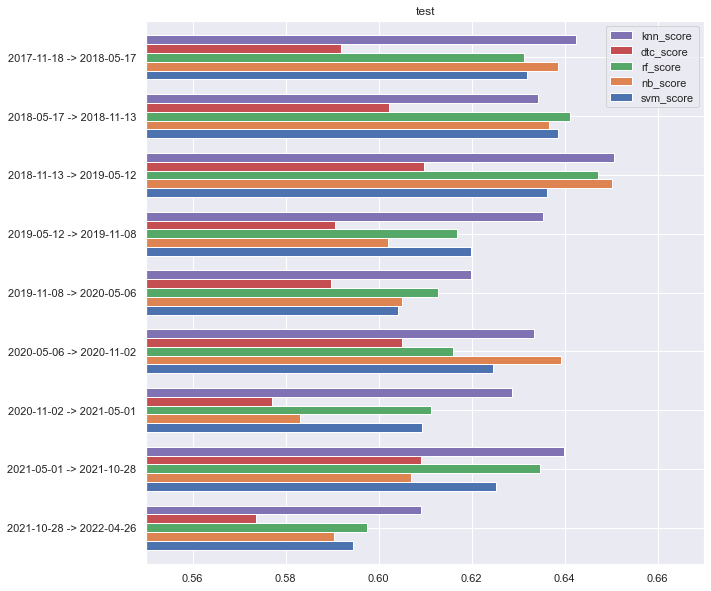

In [61]:

models_best_results.iloc[:, ::-1].plot(kind="barh", figsize=(10,10), xlim=(.55,.67), width=.75, legend='reverse')
plt.title("test")
plt.show()



### Feature Importances

In [62]:
xtrain, xtest, ytrain, ytest = convert_dataset_for_classification_models(df=recent_matches_dataset, seed=1)


dtc = DecisionTreeClassifier(random_state=69)
dtc.fit(xtrain, ytrain)
print(f'The DecisionTreeClassifier model has a prediction accuracy of {round(dtc.score(xtest, ytest)*100,2)}%')

rf = RandomForestClassifier(criterion='entropy', n_estimators = 100, random_state = 69)
rf.fit(xtrain, ytrain)
print(f'The RandomForestClassifier model has a prediction accuracy of {round(rf.score(xtest, ytest)*100,2)}%')



The DecisionTreeClassifier model has a prediction accuracy of 60.72%
The RandomForestClassifier model has a prediction accuracy of 61.22%


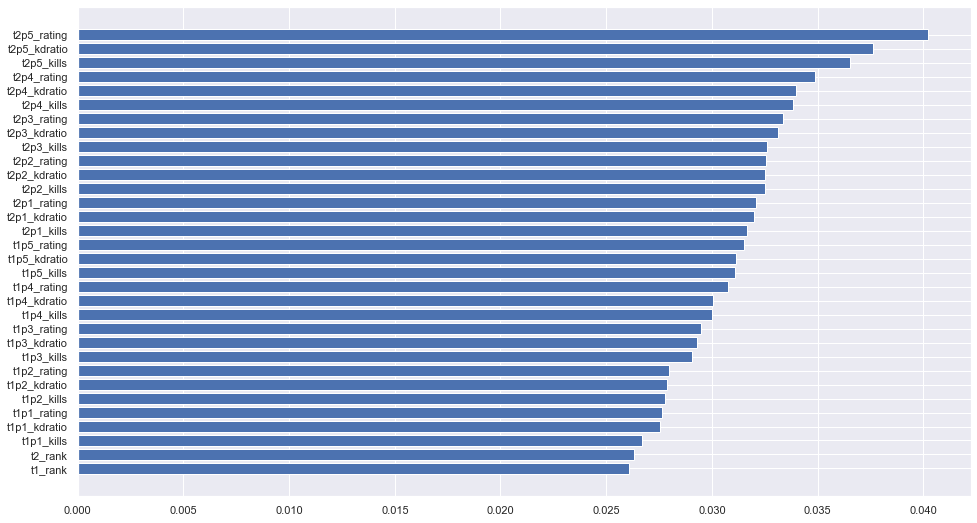

In [63]:
fig = plt.figure(figsize=(16, 9))
sorted_feat = rf.feature_importances_.argsort()
plt.barh(xtrain.columns,rf.feature_importances_[sorted_feat])

plt.show()

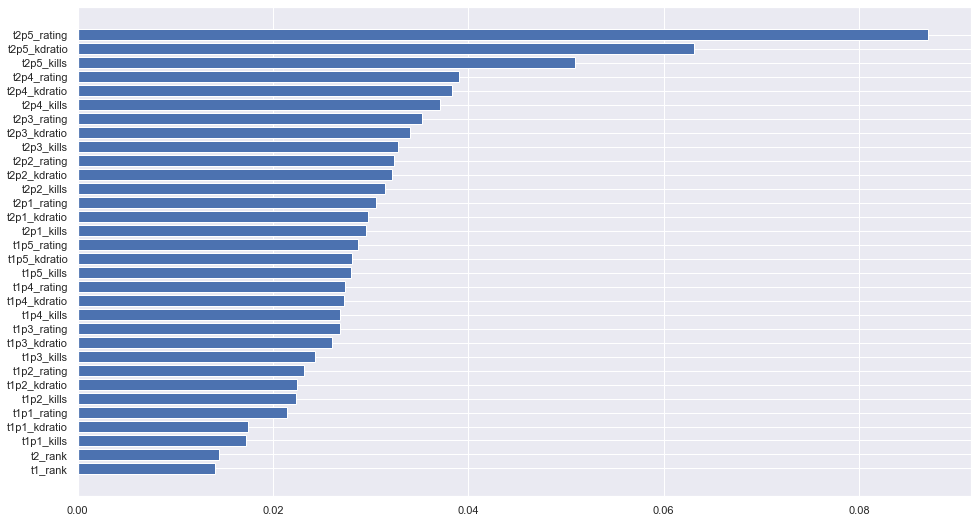

In [64]:
fig = plt.figure(figsize=(16, 9))
sorted_feat = dtc.feature_importances_.argsort()
plt.barh(xtrain.columns,dtc.feature_importances_[sorted_feat])

plt.show()

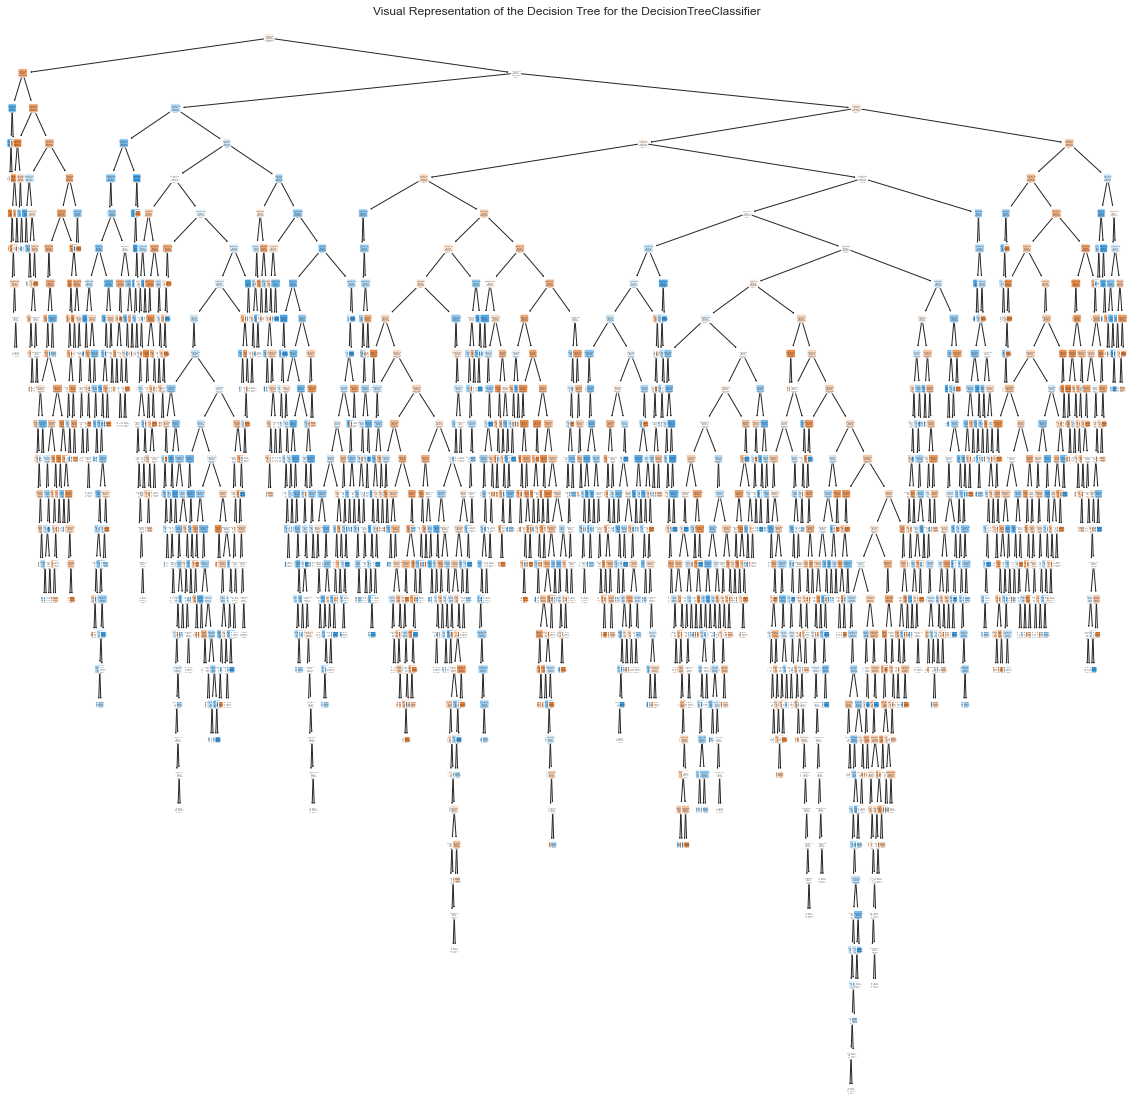

In [65]:
fig = plt.figure(figsize=(20, 20))

plot_tree(dtc, 
          feature_names=xtrain.columns,
          class_names=["t1", "t2"], 
          filled=True, impurity=True, 
          rounded=True)
plt.title("Visual Representation of the Decision Tree for the DecisionTreeClassifier")
plt.show()

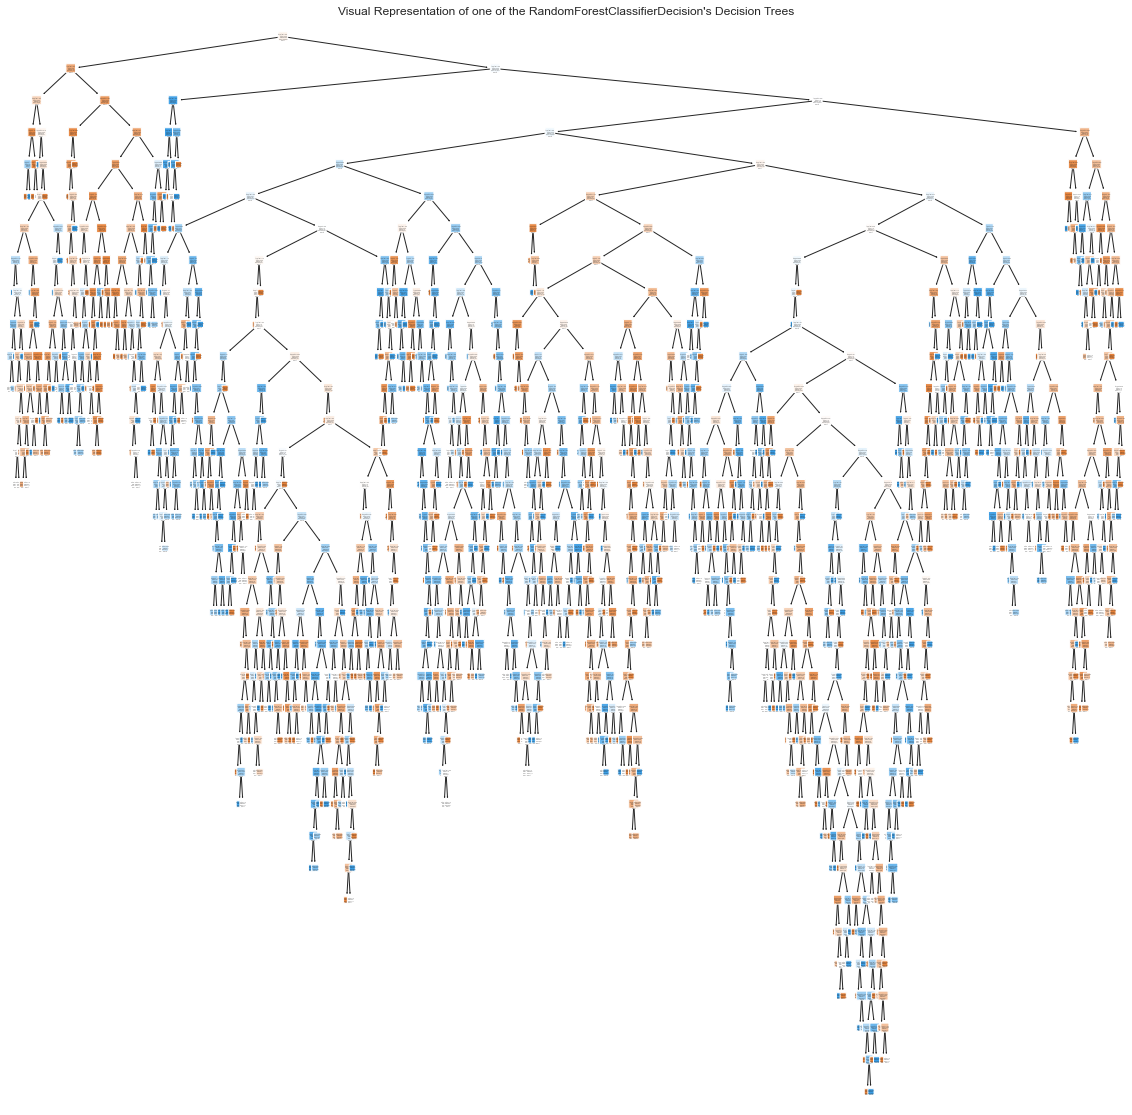

In [66]:
fig = plt.figure(figsize=(20, 20))

plot_tree(rf.estimators_[0], 
          feature_names=xtrain.columns,
          class_names=["t1", "t2"], 
          filled=True, impurity=True, 
          rounded=True)
plt.title("Visual Representation of one of the RandomForestClassifierDecision's Decision Trees")
plt.show()

-----
-----

# ROUND WIN DIFF PREDICTOR MODELS

-----

In [67]:
def convert_dataset_for_reg_models(df : DataFrame, seed : int = 1, test_set_size : float = 0.3):
    
    teams_profiles : dict[str,Series] = make_teams_profiles(df, pstat_vars=SELECTED_PSTAT_VARS)

    # convert all unranked teams to have rank of 31st position
    model_dataset = df.copy()
    model_dataset["t1_rank"].fillna(31, inplace=True)
    model_dataset["t2_rank"].fillna(31, inplace=True)

    # extract data for each team, extract player stats later
    teams_stats = model_dataset.loc[:,["winner","t1_rank", "t2_rank", "t1_name", "t2_name"]]
    # keep_dict = {}
    # print(teams_stats.shape)
    # add team player stat profiles to each entry / row of data in features dataframe
    features_dict = {}
    for index, row in teams_stats.iterrows():
        t1_name, t2_name = row["t1_name"], row["t2_name"]
        if t1_name in teams_profiles or t2_name in teams_profiles:
            if not t1_name in teams_profiles:
                t2_profile = Series(list(teams_profiles[t2_name].values), 
                    index = [f"t2{pstat_var}" for pstat_var in list(teams_profiles[t2_name].index)])
                t1_profile = Series(list(teams_profiles[t2_name].apply(lambda x: None).values), 
                    index = [f"t1{pstat_var}" for pstat_var in list(teams_profiles[t2_name].index)])
            elif not t2_name in teams_profiles:
                t1_profile = Series(list(teams_profiles[t1_name].values), 
                    index = [f"t1{pstat_var}" for pstat_var in list(teams_profiles[t1_name].index)])
                t2_profile = Series(list(teams_profiles[t1_name].apply(lambda x: None).values), 
                    index = [f"t2{pstat_var}" for pstat_var in list(teams_profiles[t1_name].index)])
            else:
                t1_profile = Series(list(teams_profiles[t1_name].values), 
                    index = [f"t1{pstat_var}" for pstat_var in list(teams_profiles[t1_name].index)])
                t2_profile = Series(list(teams_profiles[t2_name].values), 
                    index = [f"t2{pstat_var}" for pstat_var in list(teams_profiles[t2_name].index)])
            features_dict[index] = pd.concat([row, t1_profile, t2_profile])
            # keep_dict[index] = row
        # else:
            # model_dataset.drop(index, inplace=True)
    
    features = DataFrame.from_dict(features_dict, orient="index")
    features.drop(columns=["t1_name", "t2_name"], inplace=True)
    features["winner"] = features["winner"].apply(lambda x: x == "t1")
    # print(features["winner"])
    # print(list(features.columns))

    features.fillna(0,inplace=True)

    # numerical_vars = [var for var in list(features.columns) if var[0] == "t" and var[2] == "p"]
    numerical_vars = list(features.columns)
    
    labels = model_dataset["rw_diff"].astype("int64")
    # print(features.shape, labels.shape)
    xtrain, xtest, ytrain, ytest =  train_test_split( features, labels, random_state=seed, test_size=test_set_size)

    scaler = StandardScaler()
    scaler.fit(xtrain[numerical_vars])

    xtrain[numerical_vars] = scaler.transform(xtrain[numerical_vars]) #scale the training data
    xtest[numerical_vars] = scaler.transform(xtest[numerical_vars]) #scale the testing data

    return xtrain, xtest, ytrain, ytest


xtrain, xtest, ytrain, ytest = convert_dataset_for_reg_models(recent_matches_dataset ,seed=69)
xtrain.head()


,winner,t1_rank,t2_rank,t1p1_kills,t1p1_kdratio,t1p1_rating,t1p2_kills,t1p2_kdratio,t1p2_rating,t1p3_kills,...,t2p2_rating,t2p3_kills,t2p3_kdratio,t2p3_rating,t2p4_kills,t2p4_kdratio,t2p4_rating,t2p5_kills,t2p5_kdratio,t2p5_rating
56663,0.917832,0.472193,0.404205,0.267107,1.393910,0.831304,-0.083223,0.214066,0.566515,1.730883,...,0.061890,0.598729,0.491439,0.566221,0.012550,0.422206,0.734193,0.819980,-0.042335,0.858040
51425,0.917832,0.472193,0.404205,0.146146,0.391942,0.076047,-0.220243,0.566341,-0.118703,0.532582,...,0.199377,0.699705,-0.165866,0.375260,0.591693,0.452277,0.595024,0.278241,0.629155,0.436878
19545,-1.089524,0.472193,-0.824992,-0.158986,-0.333981,-0.093345,-0.032824,-0.116845,0.034896,-0.387056,...,1.527025,1.128391,1.502225,1.746035,0.703311,1.343572,1.899299,0.875247,1.520728,1.783076
24231,0.917832,0.472193,0.404205,-1.355109,-0.583824,-1.157074,-0.375531,0.232960,-0.591389,0.971250,...,-0.298778,0.816055,-1.789770,-0.340551,1.136119,0.796713,0.116341,1.617558,0.873014,0.563781
53824,-1.089524,0.472193,-0.978641,-1.376202,0.163594,-0.504977,-0.311987,-0.293237,0.024271,-0.930928,...,-0.154334,-0.358656,0.559936,-0.025957,0.165877,0.967260,0.292969,0.438839,0.399448,0.765248


## Initial Regressor Testing/Proof-of-Concept

In [68]:
def initial_test_rw_diff_models():
    xtrain, xtest, ytrain, ytest = convert_dataset_for_reg_models(dataset_partitions.iloc[1] ,seed=69)
    # print(list(xtrain.columns))

    knn = KNeighborsRegressor(n_neighbors=15)
    knn.fit(xtrain,ytrain)
    knn_ypred = knn.predict(xtest)
    print(list(knn_ypred)[:10])
    print(list(ytest)[:10])
    print(f'The KNeighborsRegressor has a RMSE of {round(mean_squared_error(ytest, knn_ypred, squared=False),2)}')
    print(f'The KNeighborsRegressor has a MAE of {round(mean_absolute_error(ytest, knn_ypred),2)}')


    dtc = DecisionTreeRegressor(random_state=69)
    dtc.fit(xtrain, ytrain)
    dtc_ypred = dtc.predict(xtest)
    print(f'The DecisionTreeRegressor has a RMSE of {round(mean_squared_error(ytest, dtc_ypred, squared=False),2)}')
    print(f'The DecisionTreeRegressor has a MAE of {round(mean_absolute_error(ytest, dtc_ypred),2)}')


    rf = RandomForestRegressor(criterion='squared_error', n_estimators = 100, random_state = 69)
    rf.fit(xtrain, ytrain)
    rf_ypred   = rf.predict(xtest)
    print(f'The RandomForestRegressor has a RMSE of {round(mean_squared_error(ytest, rf_ypred, squared=False),2)}')
    print(f'The RandomForestRegressor has a MAE of {round(mean_absolute_error(ytest, rf_ypred),2)}')

    svm = SVR()
    svm.fit(xtrain, ytrain)
    svm_ypred = svm.predict(xtest)
    print(f'The SVR has a RMSE of {round(mean_squared_error(ytest, svm_ypred, squared=False),2)}')
    print(f'The SVR has a MAE of {round(mean_absolute_error(ytest, svm_ypred),2)}')

# initial_test_rw_diff_models()

In [69]:
dummy_knn = KNeighborsRegressor()
print("Available params for knn():")
print(", ".join([f"{key}: {dummy_knn.get_params()[key]}" for key in dummy_knn.get_params()]))

dummy_dtc = DecisionTreeRegressor()
print("\nAvailable params for dtc():")
print(", ".join([f"{key}: {dummy_dtc.get_params()[key]}" for key in dummy_dtc.get_params()]))

dummy_rf = RandomForestRegressor()
print("\nAvailable params for rf():")
print(", ".join([f"{key}: {dummy_rf.get_params()[key]}" for key in dummy_rf.get_params()]))

dummy_svm = SVR()
print("\nAvailable params for svr():")
print(", ".join([f"{key}: {dummy_svm.get_params()[key]}" for key in dummy_svm.get_params()]))




Available params for knn():
algorithm: auto, leaf_size: 30, metric: minkowski, metric_params: None, n_jobs: None, n_neighbors: 5, p: 2, weights: uniform

Available params for dtc():
ccp_alpha: 0.0, criterion: squared_error, max_depth: None, max_features: None, max_leaf_nodes: None, min_impurity_decrease: 0.0, min_samples_leaf: 1, min_samples_split: 2, min_weight_fraction_leaf: 0.0, random_state: None, splitter: best

Available params for rf():
bootstrap: True, ccp_alpha: 0.0, criterion: squared_error, max_depth: None, max_features: auto, max_leaf_nodes: None, max_samples: None, min_impurity_decrease: 0.0, min_samples_leaf: 1, min_samples_split: 2, min_weight_fraction_leaf: 0.0, n_estimators: 100, n_jobs: None, oob_score: False, random_state: None, verbose: 0, warm_start: False

Available params for svr():
C: 1.0, cache_size: 200, coef0: 0.0, degree: 3, epsilon: 0.1, gamma: scale, kernel: rbf, max_iter: -1, shrinking: True, tol: 0.001, verbose: False


In [70]:
def tune_rw_diff_models():
    knn_reg_tuning_results = {}
    dtc_reg_tuning_results =  {}
    rf_reg_tuning_results = {}
    svm_reg_tuning_results = {}

    for daterange, part in dataset_partitions.iteritems():
        print(daterange)
        # 10 different seeds for us to average results across
        # random_states = [6, 13, 23, 24, 33, 69, 420, 666, 6969, 13666]
        # random_states = [69, 420, 666]
        random_states = [n + n**n for n in range(0,5)]
        # knn_tuning_results_dict =  {}
        xtrain, xtest, ytrain, ytest = convert_dataset_for_reg_models(df=part, seed=1)

        # xtrain, xtest, ytrain, ytest = convert_dataset_for_models(df=part, seed=seed)
        knn_params = {
            # "n_neighbors": np.arange(1, 100, 10),
            "n_neighbors": [1] + [n for n in range(10,101,10)],
            # "random_state" : random_states,
        }
        knn = KNeighborsRegressor()        
        knn_grid = GridSearchCV(estimator = knn, param_grid = knn_params, cv=5, return_train_score = True, scoring='neg_mean_absolute_error')
        knn_grid.fit(xtrain, ytrain)    
        knn_reg_tuning_results[daterange] = dict(knn_grid.best_params_) 
        # take absolute value bc cvgridsearch uses negative values for optimization
        knn_reg_tuning_results[daterange]["score"] = abs(knn_grid.best_score_)
        
        print("knn: ", ", ".join([f"{key} : {knn_grid.best_params_[key]}" for key in knn_grid.best_params_]))


        dtc_params = {
            # "n_neighbors": np.arange(1, 100, 10),
            "random_state" : random_states,
        }
        dtc = DecisionTreeRegressor()
        dtc_grid = GridSearchCV(estimator = dtc, param_grid = dtc_params, cv=5, return_train_score = True, scoring='neg_mean_absolute_error')
        dtc_grid.fit(xtrain, ytrain)    
        dtc_reg_tuning_results[daterange] = dict(dtc_grid.best_params_) 
        # take absolute value bc cvgridsearch uses negative values for optimization
        dtc_reg_tuning_results[daterange]["score"] = abs(dtc_grid.best_score_)

        print("dtc: ", ", ".join([f"{key} : {dtc_grid.best_params_[key]}" for key in dtc_grid.best_params_]))

        rf_params = {
            "n_estimators": [n for n in range(20,201,20)],
            "random_state" : random_states,
        }
        rf = RandomForestRegressor()
        rf_grid = GridSearchCV(estimator = rf, param_grid = rf_params, cv=5, return_train_score = True, scoring='neg_mean_absolute_error')
        rf_grid.fit(xtrain, ytrain)    
        rf_reg_tuning_results[daterange] = dict(rf_grid.best_params_) 
        # take absolute value bc cvgridsearch uses negative values for optimization
        rf_reg_tuning_results[daterange]["score"] = abs(rf_grid.best_score_)

        print("rf: ", ", ".join([f"{key} : {rf_grid.best_params_[key]}" for key in rf_grid.best_params_]))
            
        svm_params = {
            'C': np.arange(8, 12) * 0.1,
            # 'gamma': np.arange(1, 5) * 0.1,
            'gamma': [.1],
        }
        svm = SVR()
        svm_grid = GridSearchCV(estimator = svm, param_grid = svm_params, cv=5, return_train_score = True, scoring='neg_mean_absolute_error')
        svm_grid.fit(xtrain, ytrain)    
        svm_reg_tuning_results[daterange] = dict(svm_grid.best_params_) 
        # take absolute value bc cvgridsearch uses negative values for optimization
        svm_reg_tuning_results[daterange]["score"] = abs(svm_grid.best_score_)  
        print("svm: ", ", ".join([f"{key} : {svm_grid.best_params_[key]}" for key in svm_grid.best_params_]))

        # STORE RESULTS AFTER EACH PARTITION
        DataFrame.from_dict(knn_reg_tuning_results, orient="index").to_pickle("cache/knn_reg_tuning_results.pkl")
        DataFrame.from_dict(dtc_reg_tuning_results, orient="index").to_pickle("cache/dtc_reg_tuning_results.pkl")
        DataFrame.from_dict(rf_reg_tuning_results, orient="index").to_pickle("cache/rf_reg_tuning_results.pkl")
        DataFrame.from_dict(svm_reg_tuning_results, orient="index").to_pickle("cache/svm_reg_tuning_results.pkl")


    return knn_reg_tuning_results, dtc_reg_tuning_results, rf_reg_tuning_results, svm_reg_tuning_results
# knn_reg_tuning_results, dtc_reg_tuning_results, rf_reg_tuning_results, svm_reg_tuning_results = tune_rw_diff_models()

# DataFrame.from_dict(knn_reg_tuning_results, orient="index").to_pickle("cache/knn_reg_tuning_results.pkl")
# DataFrame.from_dict(dtc_reg_tuning_results, orient="index").to_pickle("cache/dtc_reg_tuning_results.pkl")
# DataFrame.from_dict(rf_reg_tuning_results, orient="index").to_pickle("cache/rf_reg_tuning_results.pkl")
# DataFrame.from_dict(svm_reg_tuning_results, orient="index").to_pickle("cache/svm_reg_tuning_results.pkl")


In [71]:
knn_reg_tuning_results_df = pd.read_pickle("cache/knn_reg_tuning_results.pkl")
dtc_reg_tuning_results_df = pd.read_pickle("cache/dtc_reg_tuning_results.pkl")
rf_reg_tuning_results_df = pd.read_pickle("cache/rf_reg_tuning_results.pkl")
svm_reg_tuning_results_df = pd.read_pickle("cache/svm_reg_tuning_results.pkl")

print("KNN Regression Tuning Results:")
print(knn_reg_tuning_results_df.head())
print("\nDTC Regression Tuning Results:")
print(dtc_reg_tuning_results_df.head())
print("\nRF Regression Tuning Results:")
print(rf_reg_tuning_results_df.head())
print("\nSVM Regression Tuning Results:")
print(svm_reg_tuning_results_df.head())

KNN Regression Tuning Results:
                          n_neighbors     score
2021-10-28 -> 2022-04-26           30  3.140531
2021-05-01 -> 2021-10-28           30  3.203819
2020-11-02 -> 2021-05-01           40  3.210087
2020-05-06 -> 2020-11-02           20  3.332526
2019-11-08 -> 2020-05-06           40  3.167512

DTC Regression Tuning Results:
                          random_state     score
2021-10-28 -> 2022-04-26             1  3.581666
2021-05-01 -> 2021-10-28             1  3.655842
2020-11-02 -> 2021-05-01             2  3.588441
2020-05-06 -> 2020-11-02           260  3.627666
2019-11-08 -> 2020-05-06           260  3.600732

RF Regression Tuning Results:
                          n_estimators  random_state     score
2021-10-28 -> 2022-04-26           160             6  2.934809
2021-05-01 -> 2021-10-28           180             1  2.993379
2020-11-02 -> 2021-05-01           120             2  2.918690
2020-05-06 -> 2020-11-02           160             2  3.017105
2019-11-0

In [72]:
reg_models_best_results = pd.DataFrame(knn_reg_tuning_results_df["score"].rename("knn_score"))
reg_models_best_results["dtc_score"] = dtc_reg_tuning_results_df["score"]
reg_models_best_results["rf_score"] = rf_reg_tuning_results_df["score"]
reg_models_best_results["svm_score"] = svm_reg_tuning_results_df["score"]
print(reg_models_best_results,"\n\n")

reg_models_best_results_stats = pd.DataFrame(knn_reg_tuning_results_df["score"].rename("knn_score").describe())
reg_models_best_results_stats["dtc_score"] = dtc_reg_tuning_results_df["score"].describe()
reg_models_best_results_stats["rf_score"] = rf_reg_tuning_results_df["score"].describe()
reg_models_best_results_stats["svm_score"] = svm_reg_tuning_results_df["score"].describe()
print(reg_models_best_results_stats)

                          knn_score  dtc_score  rf_score  svm_score
2021-10-28 -> 2022-04-26   3.140531   3.581666  2.934809   3.489168
2021-05-01 -> 2021-10-28   3.203819   3.655842  2.993379   3.451809
2020-11-02 -> 2021-05-01   3.210087   3.588441  2.918690   3.467474
2020-05-06 -> 2020-11-02   3.332526   3.627666  3.017105   3.515151
2019-11-08 -> 2020-05-06   3.167512   3.600732  2.961017   3.512185
2019-05-12 -> 2019-11-08   3.179703   3.668883  3.008156   3.577697
2018-11-13 -> 2019-05-12   3.318372   3.856485  3.166165   3.691381
2018-05-17 -> 2018-11-13   3.292896   3.876096  3.138574   3.737592
2017-11-18 -> 2018-05-17   3.263294   3.860816  3.109850   3.723272 


       knn_score  dtc_score  rf_score  svm_score
count   9.000000   9.000000  9.000000   9.000000
mean    3.234304   3.701847  3.027527   3.573970
std     0.069588   0.125390  0.090031   0.113796
min     3.140531   3.581666  2.918690   3.451809
25%     3.179703   3.600732  2.961017   3.489168
50%     3.210087   3.65

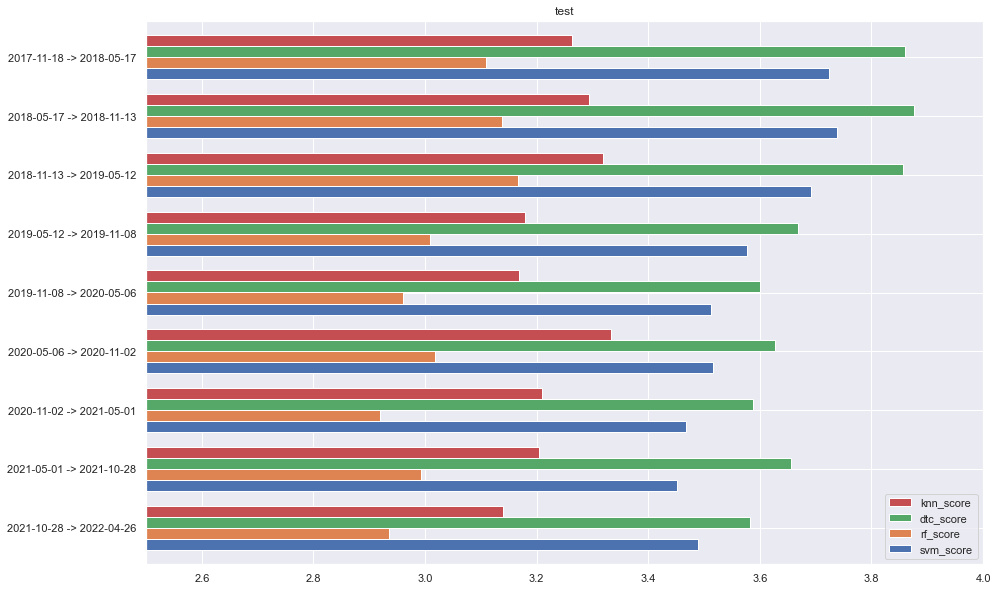

In [73]:

reg_models_best_results.iloc[:, ::-1].plot(kind="barh", figsize=(15,10), xlim=(2.5,4), width=.75, legend='reverse')
plt.title("test")
plt.show()

In [74]:
xtrain, xtest, ytrain, ytest = convert_dataset_for_classification_models(df=recent_matches_dataset, seed=1)

print(dtc_reg_tuning_results_df["random_state"].iloc[0])
dtc = DecisionTreeRegressor(random_state=dtc_reg_tuning_results_df["random_state"].iloc[0])
dtc.fit(xtrain, ytrain)

print(rf_reg_tuning_results_df["n_estimators"].iloc[0], rf_reg_tuning_results_df["random_state"].iloc[0])
rf = RandomForestRegressor(criterion='entropy', 
    n_estimators = rf_reg_tuning_results_df["n_estimators"].iloc[0], 
    random_state = rf_reg_tuning_results_df["random_state"].iloc[0])
rf.fit(xtrain, ytrain)

1


ValueError: could not convert string to float: 't1'

In [ ]:
fig = plt.figure(figsize=(16, 9))
sorted_feat = dtc.feature_importances_.argsort()
plt.barh(xtrain.columns,dtc.feature_importances_[sorted_feat])

plt.show()

AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'

<Figure size 1152x648 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(16, 9))
sorted_feat = dtc.feature_importances_.argsort()
plt.barh(xtrain.columns,dtc.feature_importances_[sorted_feat])

plt.show()